In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
%matplotlib inline

import numpy as np # numerical computation packages in python
import matplotlib.pyplot as plt # plotting routines
from scipy.integrate import odeint # solving the system of differential equations
from scipy.special import comb #number of combinations of N things taken k at a time
from scipy.special import factorial

In [15]:
#1. Write down the differential equation describing the system of chemical equations (assuming a volume of 1) 
def gene_reg(y, t):
    
    #reaction rates
    k1 = 1
    k2 = 2
    k3 = 0.02
    k4 = 0.04
    
    X, Y = y #unpacking state vector

    dX = k1 - k2*X + k3*Y*(X**2) - k4*X
    dY = k2*X - k3*Y*(X**2)
    dydt = [dX, dY]
    return dydt

In [16]:
#2. Use a package to solve the differential equation for 500 time units starting from X(0)=Y(0)=0
y0 = [0, 0] #initial conditions y0=[X Y]
t = np.linspace(0, 500, 1000) #time span
sol = odeint(gene_reg, y0, t) #solver

In [20]:
#concentrations in the time domain
plt.figure(figsize=(12,8))
plt.plot(t, sol[:, 0], '--', color='b', label='X')
plt.plot(t, sol[:, 1], '--', color='g', label='Y')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (moles)')
plt.title('Time-varying Concentration of X and Y')
plt.savefig('D_PvT.jpg')
plt.show()

In [21]:
#phase plane plot of the concentrations
plt.figure(figsize=(12,8))
plt.plot(sol[:, 0], sol[:, 1], '--', color='r')
plt.xlabel('Concentration of X (moles)')
plt.ylabel('Concentration of Y (moles)')
plt.title('Phase plane of X and Y Concentrations')
plt.savefig('D_PP.jpg')
plt.show()

In [19]:
#3. Write a Gillespie algorithm to simulate the same four chemical equation and plot the results for 500 time units

In [7]:
#define a function to choose the next time and reaction
def sample_time_reaction(a0,a):
    
    #a = set of reactions ki*hi where hi= total number of all possible combinations of molecules in reaction i
    #a0 = sum of reactions in a
    
    #generate random numbers to be used in next time and next reaction calculations
    rand = np.random.random(2)
    rand1 = rand[0]
    rand2 = rand[1]
    
    # choose next time increment dt
    dt = (1/a0)*np.log(1/rand1)
    
    # choose next reaction, mu
    num = 0
    N = rand2*a0 - a[num] #once N=<0- have found the next rection 

    while N > 0:
        num = num + 1
        N = N - a[num]

    next_react = num
    
    return dt, next_react

In [8]:
def my_gillespie(init, rates, stoch_react, stoch_prods, tmax, max_no_reacts):
     
    # step 0: input rate values, initial contidions values and initialise time and reactions counter   

    # define the system
    stoch = stoch_react + stoch_prods
    s = np.shape(stoch)
    num_rxn = s[0] #number of reactions
    num_spec = s[1] #number of species

    # initialise current time, current species variables
    current_t = 0
    current_species = init
    # initialise time and reaction counters
    t_count = 0
    react_count = 0

    # preallocating variables to store time and molecule numbers
    store_t = np.zeros((2*max_no_reacts, 1))
    store_mols = np.zeros((2*max_no_reacts, num_spec))
    store_r = np.zeros((2*max_no_reacts, 1))

    # store current time and state of system
    store_t[t_count] = current_t
    store_mols[t_count,:] = current_species

    #while react_count < max_no_reacts:
    while current_t < tmax:
         
        # step 1: calculate ai and a0
        a = np.ones((num_rxn,1))

        for i in range(num_rxn):
            hi = 1
            for j in range(len(init)):

                # check the reactant is involved in this reaction
                if stoch_react[i,j] == 0:
                    continue
                else:

                    # check the reactant has molecules available
                    if current_species[j] <= 0:
                        hi = 0
                        continue
                    else:
                        hi = hi*comb(current_species[j],np.absolute(stoch_react[i,j]),exact=True)*factorial(np.absolute(stoch_react[i,j]))

            a[i] = hi*rates[i]

        a0 = sum(a)
  
        # step 2: choose next t and r

        tr = sample_time_reaction(a0,a) # tr = [dt, next_r]
        dt = tr[0]
        next_r = tr[1]
 
        # step 3: update and store system

        # update system
        current_t = current_t + dt
        current_species = current_species + np.transpose(stoch[next_r,:])

        # update time counter and reaction counter
        t_count = t_count + 1
        react_count = react_count + 1
        
        if (t_count < 2*max_no_reacts):
            # store current system
            store_t[t_count] = current_t
            store_mols[t_count,:] = current_species 
            store_r[t_count] = next_r

    # store final output
    store_t = store_t[:t_count]
    store_mols = store_mols[:t_count,:]
    store_r = store_r[:t_count]
    
    return store_t, store_mols, store_r

In [9]:
#gillespie alogrithm parameters

#effect reactions have on each of the species
stoch_react = np.array([[0,0], [-1,0], [-2,-1], [-1,0]])
stoch_prods = np.array([[1,0], [0,1], [3,0], [0,0]])

#reaction rates
k1 = 1
k2 = 2
k3 = 0.02
k4 = 0.04
rates = np.array([k1, k2, k3, k4])

#initial species concentrations
init = np.array([0, 0]) #[X=0, Y=0]

# specify the maximum time, tmax, and maximum number of reactions, max_no_react
tmax = 500
max_no_react = 10**6

In [12]:
#results = [store_t, store_mols, store_r]
results = my_gillespie(init, rates, stoch_react, stoch_prods, tmax, max_no_react)
store_t = results[0] #array of time steps
store_mols = results[1] #array containing the number of molecules at each time step
store_r = results[2] #array of reactions which took place at each time step

In [22]:
#concentrations in the time domain
plt.figure(figsize=(12,8))
plt.plot(store_t, store_mols[:, 0], color='b', label='X')
plt.plot(store_t, store_mols[:, 1], color='g', label='Y')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (moles)')
plt.title('Time-varying Concentration of X and Y')
plt.savefig('S_PvT.jpg')
plt.show()

In [23]:
#phase plane plot of the concentrations
plt.figure(figsize=(12,8))
plt.plot(store_mols[:, 0], store_mols[:, 1], color='r')
plt.xlabel('Concentration of X (moles)')
plt.ylabel('Concentration of Y (moles)')
plt.title('Phase plane of X and Y Concentrations')
plt.savefig('S_PP.jpg')
plt.show()

In [ ]:
#comparing deterministic and stochastic results

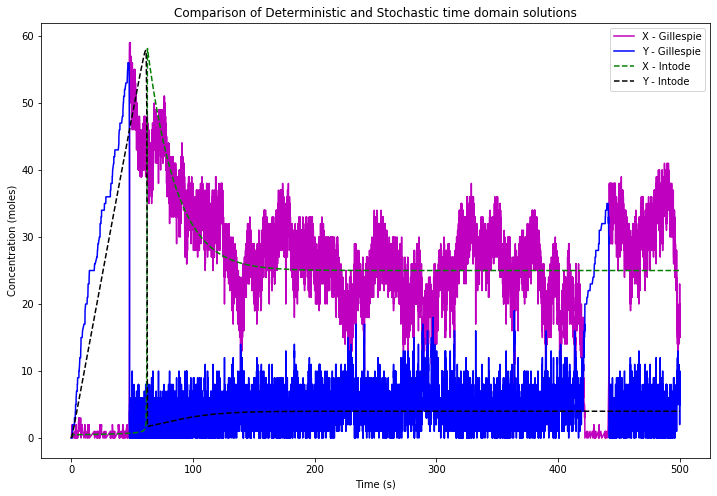

In [140]:
#concentrations in the time domain
plt.figure(figsize=(12,8))
plt.plot(store_t, store_mols[:, 0], color='m', label='X - Gillespie')
plt.plot(store_t, store_mols[:, 1], color='b', label='Y - Gillespie')
plt.plot(t, sol[:, 0], '--', color='g', label='X - Intode')
plt.plot(t, sol[:, 1], '--', color='k', label='Y - Intode')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (moles)')
plt.title('Comparison of Deterministic and Stochastic time domain solutions')
plt.savefig('PvT.jpg')
plt.show()

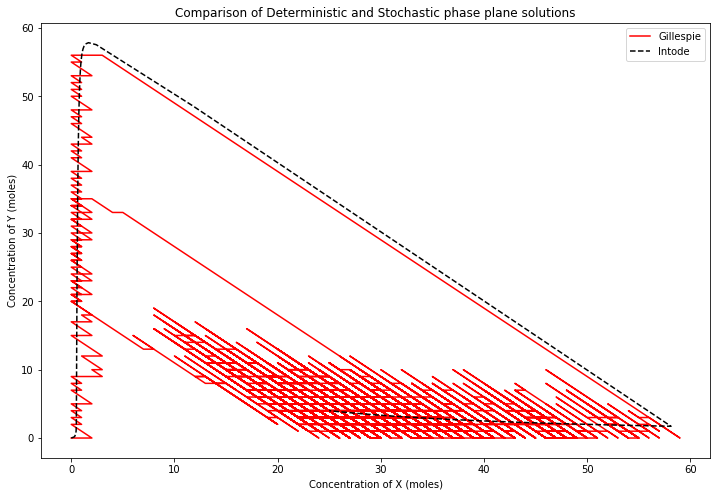

In [143]:
#phase plane plot of the concentrations
plt.figure(figsize=(12,8))
plt.plot(store_mols[:, 0], store_mols[:, 1], color='r', label="Gillespie")
plt.plot(sol[:, 0], sol[:, 1], "--", color='k', label="Intode")
plt.legend(loc='best')
plt.xlabel('Concentration of X (moles)')
plt.ylabel('Concentration of Y (moles)')
plt.title('Comparison of Deterministic and Stochastic phase plane solutions')
plt.savefig('PP.jpg')
plt.show()